<a href="https://colab.research.google.com/github/madhurchouhan7/PyTorch/blob/main/Pneumonia_Detection/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📋 Pneumonia Detection with ResNet & PyTorch**

### **Project Goal**
To build a Deep Learning model that looks at Chest X-Ray images and predicts if a patient has **Pneumonia** or is **Normal**.

### **1. Imports and Setup**
*   **`torch` & `torchvision`**: The main PyTorch libraries for building AI and handling images.
*   **`os`**: To navigate files on your computer.
*   **`matplotlib` & `seaborn`**: For drawing graphs and showing images.

In [232]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

Makes the chart appear directly inside the notebook

In [233]:
# %matplotlib inline

### **2. Configuration (Constants)**
*   **`IMAGE_SIZE = 150`**: Neural Networks need fixed inputs. We will squash all images (big or small) to 150x150 pixels.
*   **`BATCH_SIZE = 32`**: The "Mini-Batch" size. The model will study 32 images at a time before updating its brain.
*   **`DATA_DIR`**: The path where your folders (train/test/val) live.

In [234]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [235]:
# CONSTANTS
IMAGE_SIZE = 128
BATCH_SIZE = 64  # ⚡ Increased from 32 (2x faster!)
DATA_DIR = '/content/drive/MyDrive/chest_xray'  # Update this path to where you uploaded the data

In [236]:
DATA_DIR

'/content/drive/MyDrive/chest_xray'

In [237]:
print(f"🖥️  Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"⚡ CUDA Available: {torch.cuda.is_available()}")
print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Test actual speed
import time
x = torch.randn(1000, 1000).cuda()
start = time.time()
y = x @ x
torch.cuda.synchronize()
print(f"⏱️  GPU Speed Test: {(time.time()-start)*1000:.2f}ms")

🖥️  Device: Tesla T4
⚡ CUDA Available: True
📊 GPU Memory: 15.83 GB
⏱️  GPU Speed Test: 1.05ms


### **3. Data Transforms (The Preprocessing Pipeline)**
Before an image enters the model, it must be "cleaned" and prepared.

*   **`Grayscale(3)`**:
     *   *Concept:* X-rays are Black & White (1 channel), but ResNet expects Color (3 channels).
     *   *Trick:* We duplicate the B&W layer 3 times to "fake" a color image so ResNet accepts it.

*   **`Resize`**: Ensures every image is exactly 150x150.

*   **`ToTensor`**: Converts the image from **Pixels (0-255)** to **Math Numbers (0.0-1.0)**.

*   **`Normalize`**: Shifts the math numbers to be between **-1 and 1**. This helps the model learn faster (stable gradients).

In [238]:
# TRANSFORMERS (grayscale, resize, to tensor, normalize)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### **4. Loading Data (The "Bridge")**
*   **`ImageFolder`**: PyTorch's magic tool. It looks at folder names ("Normal", "Pneumonia") and automatically converts them into labels (0, 1).
*   **`DataLoader`**: The "Delivery Truck". It gathers images from the hard drive, packages them into batches of 32, and delivers them to the GPU.
    *   **`shuffle=True` (Train)**: Critical! We mix up the cards so the model doesn't memorize the order.     
    *   **`shuffle=False` (Test)**: We don't need to shuffle when testing.

In [239]:
# LOAD DATASETS

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

# ⚡ Optimized DataLoaders for speed
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,           # Parallel loading
    pin_memory=True,         # Faster GPU transfer
    persistent_workers=True  # Keep workers alive
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("✅ Classes : ", train_dataset.classes)
print("✅ Dataset sizes : Train", len(train_dataset))
print("✅ Dataset sizes : Validation", len(val_dataset))
print("✅ Dataset sizes : Test", len(test_dataset))

✅ Classes :  ['NORMAL', 'PNEUMONIA']
✅ Dataset sizes : Train 5217
✅ Dataset sizes : Validation 16
✅ Dataset sizes : Test 624


In [240]:
print(len(train_dataset))

5217


In [241]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### **5. Data Visualization (Checking for Imbalance)**
*   **The Problem:** In medical data, "Disease" cases are often rare. If we have 1000 Normal and only 50 Pneumonia, the model might just guess "Normal" every time.
*   **The Fix:** We plot a bar chart to see if we need to fix this (e.g., using Weighted Loss later).

**🚀 PERFORMANCE TIP:**
*   I replaced your old code `[label for...]` which loaded *every image pixel* (taking minutes).
*   I used `train_dataset.targets` which reads *only the labels* (taking milliseconds).

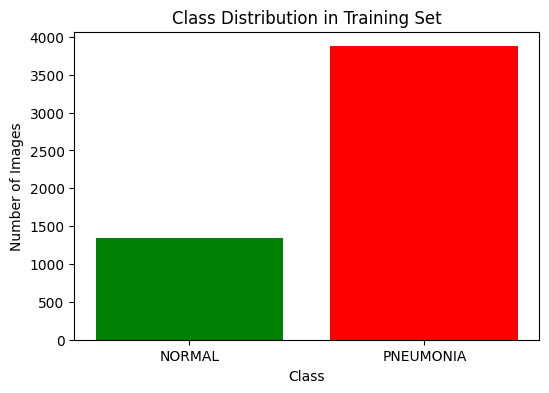

In [242]:
from collections import Counter
import matplotlib.pyplot as plt

# FAST WAY: Access the labels directly from the list stored in memory
# This takes 0.01 seconds instead of 10 minutes
labels = train_dataset.targets
label_counts = Counter(labels)

class_names = train_dataset.classes
class_labels = [class_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# PLOTTING
plt.figure(figsize=(6, 4))
plt.bar(class_labels, counts, color=['green', 'red'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

### **6. Sanity Check (View the Images)**
*   **Concept:** Always look at your data! Did the resize work? Is "Pneumonia" actually labeled correctly?
*   **`unnormalize`**: The images are currently number ranges [-1, 1] (weird colors). We calculate `img * 0.5 + 0.5` to bring them back to  so our eyes can see them normally.

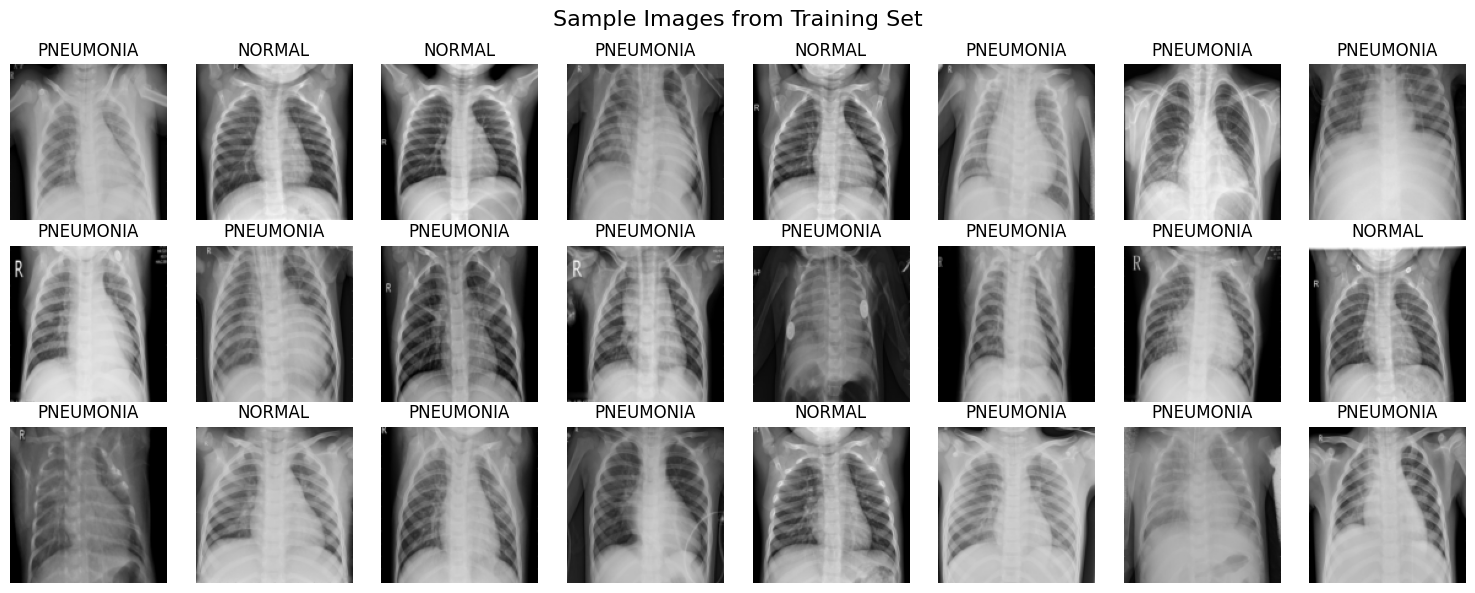

In [243]:
def show_batch(dl, class_names):

    # Fetch one batch from the dataloader
    images, labels = next(iter(dl))
    fig, axes = plt.subplots(3, 8, figsize=(15, 6))

    # Show images up to batch size
    num_images = len(images)
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            img = images[i].numpy().transpose((1, 2, 0))

            img = (img * 0.5) + 0.5  # unnormalize
            ax.imshow(img)
            ax.set_title(class_names[labels[i]])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle("Sample Images from Training Set", fontsize=16)
    plt.tight_layout()
    plt.show()

show_batch(train_loader, train_dataset.classes)

In [244]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [245]:
class PneumoniaCNN(nn.Module):
    def __init__(self, input_size=150):
        super(PneumoniaCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Calculate flattened size dynamically
        # After 3 pooling layers: input_size // 2 // 2 // 2
        final_size = input_size // 8
        flattened_size = 128 * final_size * final_size

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [246]:
import torch.optim as optim

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize model with correct input size
model = PneumoniaCNN(input_size=IMAGE_SIZE).to(device)
model = torch.compile(model)

# handle class imbalance : calculate weights
labels = [label for _, label in train_dataset.imgs]
class_counts = Counter(labels)
total = sum(class_counts.values())
weights = [total / class_counts[i] for i in range(len(class_counts))]

# Define loss function with weights
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [247]:
from torch.cuda.amp import GradScaler
from torch import amp

scaler = GradScaler()

def train_model(model, loader):
    model.train()
    total_loss, correct = 0, 0

    pbar = tqdm(loader, desc='Training', unit='batch')

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # ⚡ MIXED PRECISION: 2-3x faster!
        with amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Use scaler instead of regular backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

        pbar.set_postfix({'loss': total_loss / len(loader), 'accuracy': correct / len(loader.dataset)})

    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

/tmp/ipython-input-3370095651.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [248]:
def validate_model(model, loader):
    model.eval()
    total_loss, correct = 0, 0

    pbar = tqdm(loader, desc="Validating", leave=False)

    with torch.no_grad():
        # ⚡ Use mixed precision for validation too
        with amp.autocast(device_type='cuda'):
            for images, labels in pbar:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()

                pbar.set_postfix({'loss': total_loss / len(loader), 'accuracy': correct / len(loader.dataset)})

    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

In [249]:
NUM_EPOCHS = 5  ## change to 25 for better results
best_val_accuracy = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(NUM_EPOCHS + 1):
    train_loss, train_accuracy = train_model(model, train_loader)

    # ⚡ Validate every 2 epochs (except first and last)
    if epoch % 2 == 0 or epoch == NUM_EPOCHS:
        val_loss, val_accuracy = validate_model(model, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_accuracy)

        print(f"Epoch {epoch}/{NUM_EPOCHS}  "
              f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}  "
              f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}", flush=True)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_pneumonia_cnn.pth')
            print("=> Saved Best Model", flush=True)
    else:
        print(f"Epoch {epoch}/{NUM_EPOCHS}  "
              f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}", flush=True)

print(f"🎯 Best validation Accuracy: {best_val_accuracy:.4f}")

Training: 100%|██████████| 82/82 [02:03<00:00,  1.50s/batch, loss=0.305, accuracy=0.874]
                                                                                     

Epoch 0/5  Train Loss: 0.3053, Acc: 0.8741  Val Loss: 0.9089, Acc: 0.6875
=> Saved Best Model


Training: 100%|██████████| 82/82 [01:56<00:00,  1.42s/batch, loss=0.1, accuracy=0.962]

Epoch 1/5  Train Loss: 0.1005, Acc: 0.9619



Training: 100%|██████████| 82/82 [01:54<00:00,  1.40s/batch, loss=0.0911, accuracy=0.965]
                                                                                     

Epoch 2/5  Train Loss: 0.0911, Acc: 0.9655  Val Loss: 0.1823, Acc: 0.9375
=> Saved Best Model


Training: 100%|██████████| 82/82 [01:55<00:00,  1.41s/batch, loss=0.0727, accuracy=0.971]

Epoch 3/5  Train Loss: 0.0727, Acc: 0.9714



Training: 100%|██████████| 82/82 [01:53<00:00,  1.39s/batch, loss=0.0621, accuracy=0.974]
                                                                                     

Epoch 4/5  Train Loss: 0.0621, Acc: 0.9743  Val Loss: 0.1127, Acc: 0.9375


Training: 100%|██████████| 82/82 [01:55<00:00,  1.41s/batch, loss=0.0515, accuracy=0.981]
                                                                                

Epoch 5/5  Train Loss: 0.0515, Acc: 0.9806  Val Loss: 0.1204, Acc: 1.0000
=> Saved Best Model
🎯 Best validation Accuracy: 1.0000


In [250]:
IMAGE_SIZE = 128

# safer medical augmentation for training

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.RandomRotation(degrees=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

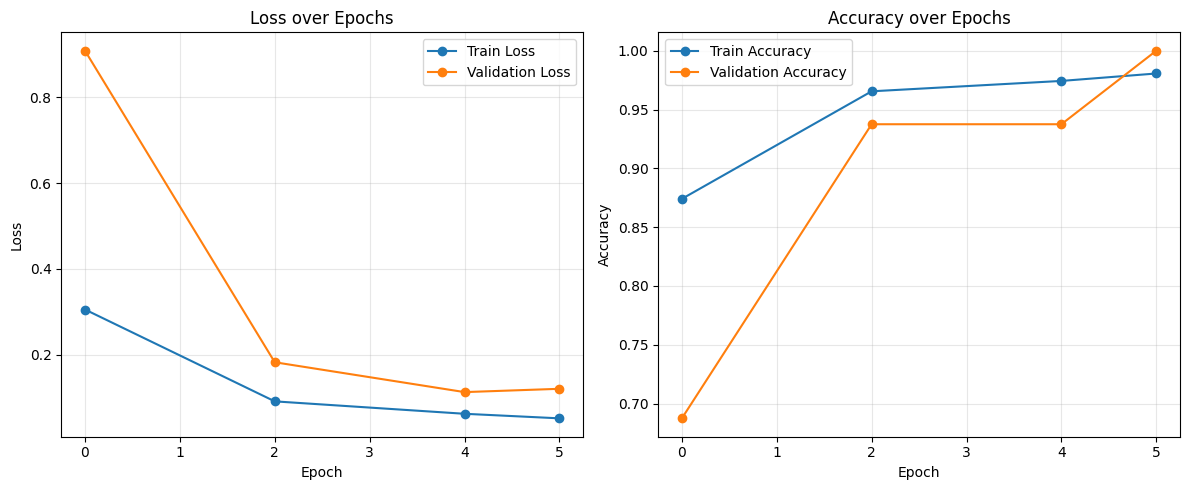

In [251]:
validation_epochs = [i for i in range(NUM_EPOCHS + 1) if i % 2 == 0 or i == NUM_EPOCHS]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(validation_epochs, train_losses, label='Train Loss', marker='o')
plt.plot(validation_epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(validation_epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(validation_epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [252]:
test_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [253]:
# ⚠️ NOTE: This cell redefines datasets - only run if you want to use augmented transforms
# Otherwise, use the datasets already loaded in cell 15

# Use the DATA_DIR from earlier (Google Drive path)
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_val_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_val_transform)

BATCH_SIZE = 64  # Match the optimized batch size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)

class_names = train_dataset.classes
print("✅ Classes : ", class_names)

✅ Classes :  ['NORMAL', 'PNEUMONIA']


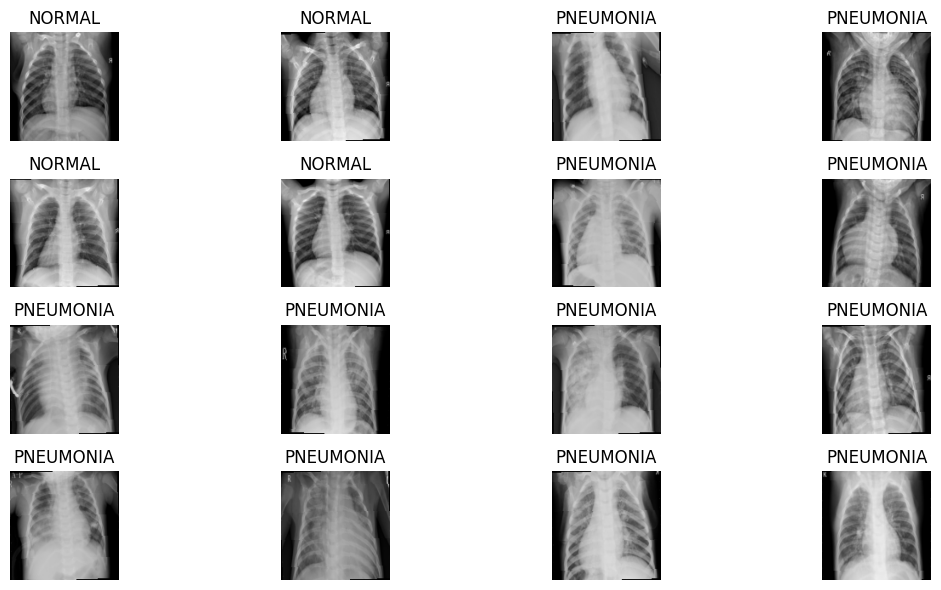

In [254]:
# get a batch of training data

images, labels = next(iter(train_loader))

# denormalize images for visualization
def denormalize(img):
    img = img * 0.5 + 0.5  # unnormalize
    img = img.numpy().transpose((1, 2, 0))
    return img


# plot a grid of images
plt.figure(figsize=(12, 6))
for i in range(min(BATCH_SIZE, 16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(denormalize(images[i]))
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [255]:
from torchvision import models

model = models.resnet18(weights="IMAGENET1K_V1")
model.conv_block1 = nn.Conv2d(1, 64, kernel_size = 7, stride=2, padding=3, bias=False)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [256]:
# Training Loop with early stopping and checkpointing

import copy

# CONFIGURATIONS
NUM_EPOCHS = 25
PATIENCE = 5  # for early stopping
BEST_MODEL_PATH = 'best_resnet18_pneumonia.pth'

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-6)

# logging
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# early stopping
best_val_accuracy = 0.0
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss, correct , total= 0, 0, 0

    for images, lable in train_loader:
        images = images.to(device)
        lable = lable.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, lable)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.max(1)[1]
        correct += preds.eq(lable).sum().item()
        total += lable.size(0)


    train_loss /= total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # validation phase
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, lable in val_loader:
            images = images.to(device)
            lable = lable.to(device)

            outputs = model(images)
            loss = criterion(outputs, lable)

            val_loss += loss.item()
            preds = outputs.max(1)[1]
            correct += preds.eq(lable).sum().item()
            total += lable.size(0)

    val_loss /= total
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}  Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}  Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}")

    # check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        epochs_no_improve = 0
        print("📌 Best model saved.")
    else:
        epochs_no_improve += 1

        # early stopping
        if epochs_no_improve >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

# load best model weights
model.load_state_dict(best_model_wts)
print(f"✅ Training completed. Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 1/25  Train Loss: 0.0000, Acc: 0.9557  Val Loss: 0.0284, Acc: 0.7500
📌 Best model saved.
Epoch 2/25  Train Loss: 0.0000, Acc: 0.9787  Val Loss: 0.0029, Acc: 1.0000
📌 Best model saved.
Epoch 3/25  Train Loss: 0.0000, Acc: 0.9806  Val Loss: 0.0088, Acc: 0.9375
Epoch 4/25  Train Loss: 0.0000, Acc: 0.9847  Val Loss: 0.0138, Acc: 0.8750
Epoch 5/25  Train Loss: 0.0000, Acc: 0.9843  Val Loss: 0.0336, Acc: 0.7500
Epoch 6/25  Train Loss: 0.0000, Acc: 0.9860  Val Loss: 0.0104, Acc: 0.9375
Epoch 7/25  Train Loss: 0.0000, Acc: 0.9918  Val Loss: 0.0033, Acc: 1.0000
⏹️ Early stopping triggered.
✅ Training completed. Best Validation Accuracy: 1.0000


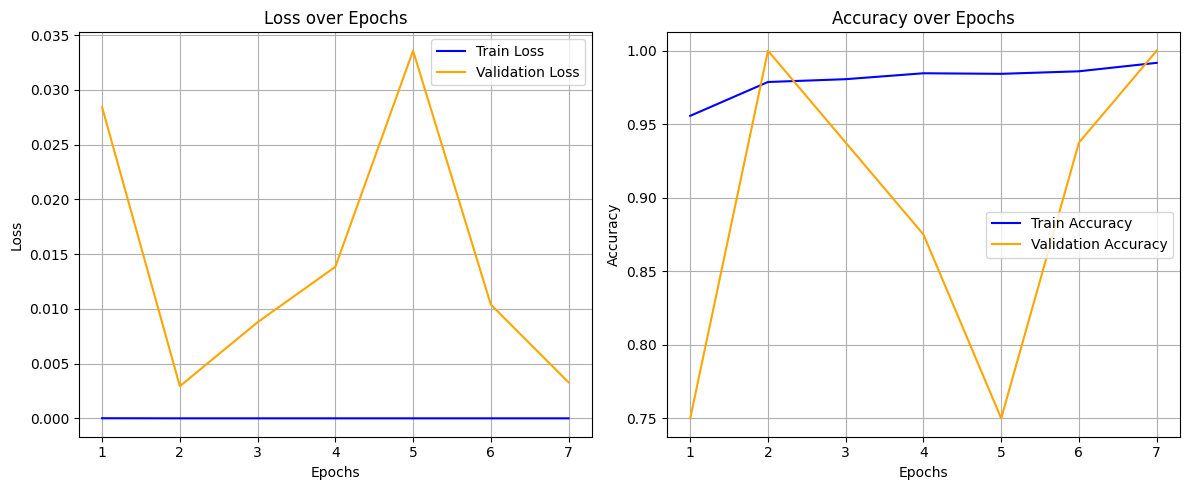

In [257]:
epoch_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# loss plot
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_losses, label='Train Loss', color='blue')
plt.plot(epoch_range, val_losses, label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epoch_range, val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

📊 Classification Report:

              precision    recall  f1-score   support

      Normal       0.95      0.74      0.83       234
   Pneumonia       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



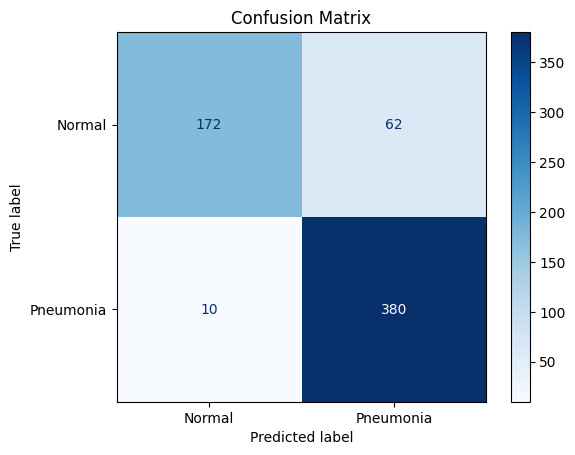

In [258]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# put model in evaluation mode
model.eval()

# collect all predictions and true labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.max(1)[1]

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# generate classification report
class_names = ['Normal', 'Pneumonia']
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

/tmp/ipython-input-2137095924.py:40: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


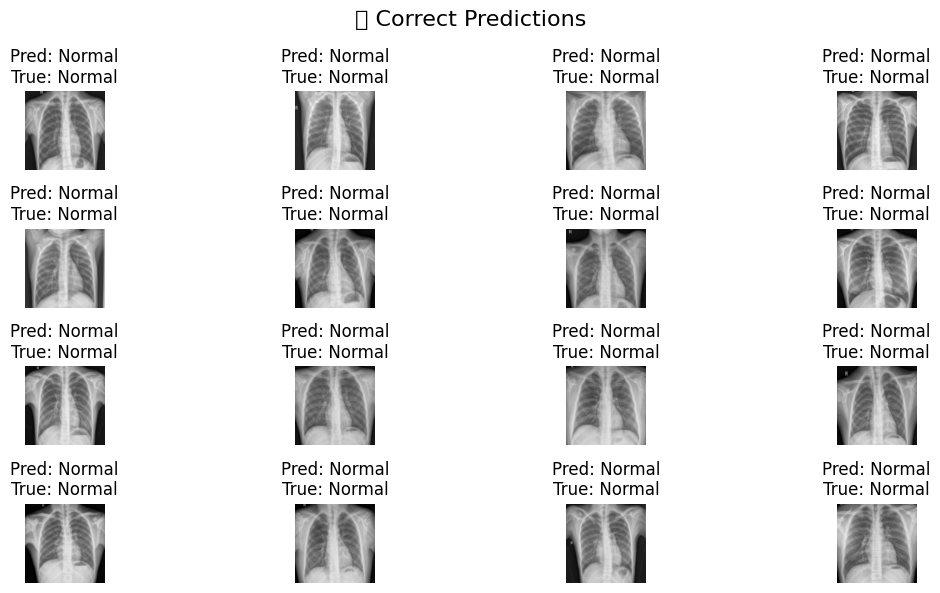

/tmp/ipython-input-2137095924.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


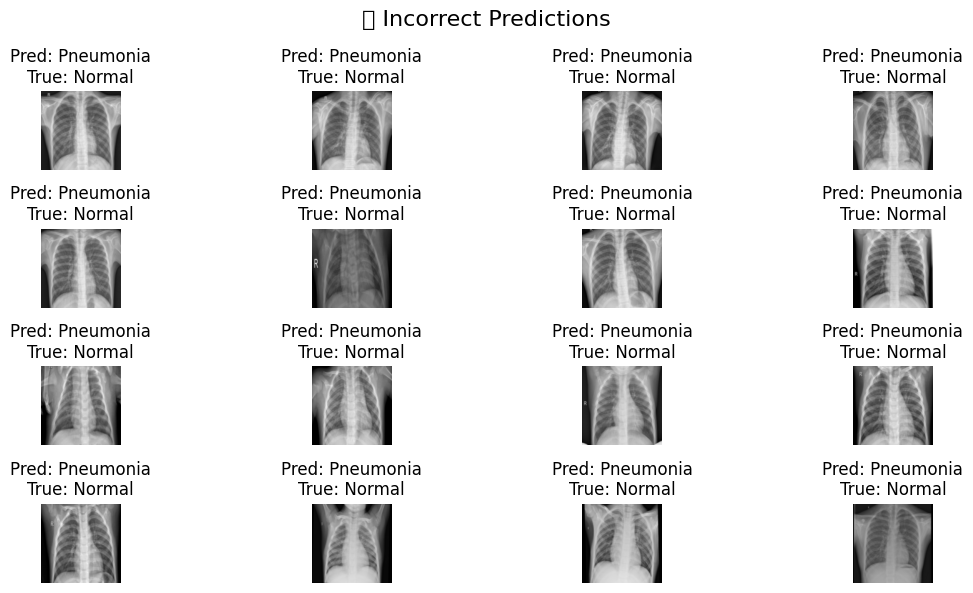

In [259]:
# step 1. generate predictions on True labels
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.max(1)[1]

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# step 2. Find correct and incorrect predictions
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

correct_indices = np.where(all_preds == all_labels)[0]
incorrect_indices = np.where(all_preds != all_labels)[0]


# step 3. Visualize some correct predictions
def show_images(indices, title, n=16):
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices[:n]):
        image, label = test_dataset[idx]
        image = denormalize(image)

        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        plt.title(f"Pred: {class_names[all_preds[idx]]}\nTrue: {class_names[label]}")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# step 4. Show correct predictions
show_images(correct_indices, "✅ Correct Predictions")
show_images(incorrect_indices, "❌ Incorrect Predictions")

In [260]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Labels for entire training dataset (flattened)
all_labels = [label for _, label in train_dataset]  # or your raw labels array
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class Weights:", class_weights)

Class Weights: tensor([1.9437, 0.6732], device='cuda:0')


In [261]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [263]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=2, min_lr=1e-6)

# Early stopping setup
best_val_acc = 0
early_stop_counter = 0
PATIENCE = 5
EPOCHS = 20

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}  Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Learning rate update
    scheduler.step(val_acc)

    # Checkpoint and early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "resnet18_pneumonia_best.pth")
        print("📌 Best model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

print("✅ Training complete.")
# Load best model
model.load_state_dict(torch.load("resnet18_pneumonia_best.pth"))


Epoch 1/20  Train Loss: 0.1076, Acc: 0.9596  Val Loss: 0.2052, Acc: 0.9375
📌 Best model saved.
Epoch 2/20  Train Loss: 0.0641, Acc: 0.9768  Val Loss: 0.2165, Acc: 0.8750
Epoch 3/20  Train Loss: 0.0542, Acc: 0.9791  Val Loss: 0.3976, Acc: 0.8750
Epoch 4/20  Train Loss: 0.0549, Acc: 0.9808  Val Loss: 0.3085, Acc: 0.8750
Epoch 5/20  Train Loss: 0.0387, Acc: 0.9854  Val Loss: 0.1066, Acc: 1.0000
📌 Best model saved.
Epoch 6/20  Train Loss: 0.0215, Acc: 0.9912  Val Loss: 0.0273, Acc: 1.0000
Epoch 7/20  Train Loss: 0.0167, Acc: 0.9935  Val Loss: 0.3659, Acc: 0.8750
Epoch 8/20  Train Loss: 0.0202, Acc: 0.9933  Val Loss: 0.1508, Acc: 0.9375
Epoch 9/20  Train Loss: 0.0100, Acc: 0.9965  Val Loss: 0.0515, Acc: 1.0000
Epoch 10/20  Train Loss: 0.0096, Acc: 0.9969  Val Loss: 0.0622, Acc: 1.0000
⏹️ Early stopping triggered.
✅ Training complete.


<All keys matched successfully>

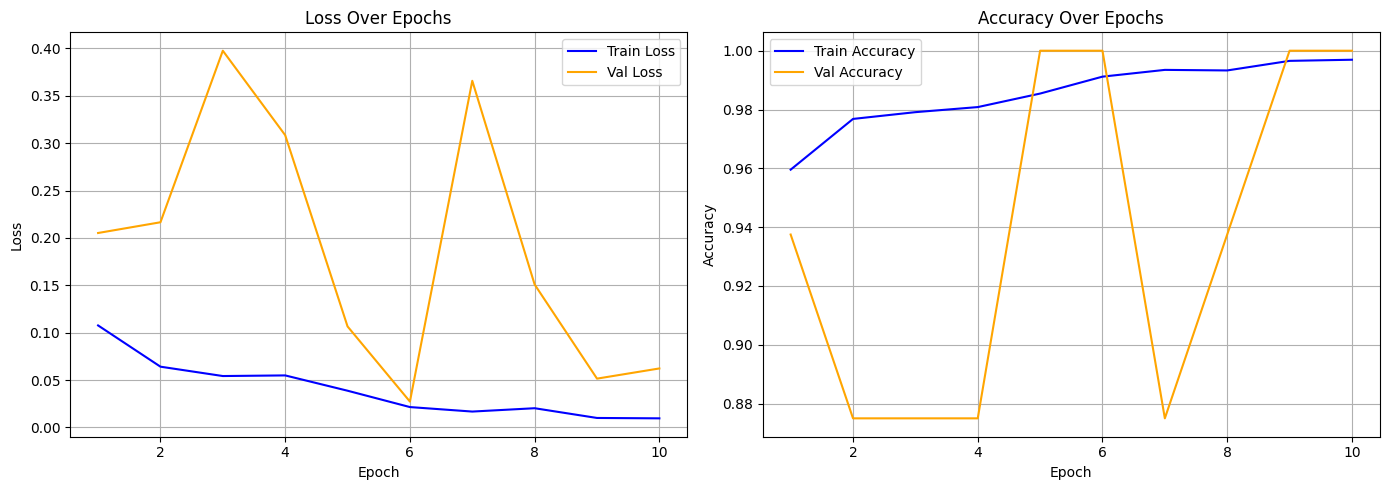

In [264]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# 📉 Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Val Loss', color='orange')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 📈 Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy', color='orange')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

      Normal       0.99      0.50      0.67       234
   Pneumonia       0.77      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624



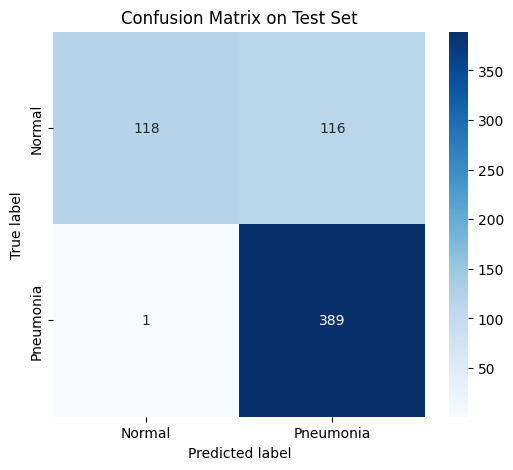

In [265]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()